In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




# Plan: download all .svs in cohort
# patch and filter and upload .pngs into kaggle
# train and run in kaggle
#


SyntaxError: unexpected EOF while parsing (384316375.py, line 25)

# Custom Dataset class for pytorch

In [2]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image


class PatchDataset(Dataset):
    # @annotations_file : path to the Slide ID, necrosis percent csv 
    # @img_dir : path to the directory where patches are
    # @transfrom : inherited
    # @target_transform : inherited
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
       # self.normalize = normalize
        self.patch_IDs = os.listdir(self.img_dir)
        if ".DS_Store" in self.patch_IDs : self.patch_IDs.remove(".DS_Store")
        
        
        self.slide_map = {}
        
        for idx in self.img_labels.index :
            self.slide_map[self.img_labels['Slide_ID'][idx]] = self.img_labels["Necrosis_Percent"][idx]


    # return num patches NOT num slides
    def __len__(self):
        return len(self.patch_IDs)

    # @idx : index of a patch
    # return patch image for requested patch ID, its label, and the parent slide ID
    def __getitem__(self, idx):
        patch = self.patch_IDs[idx]
        slide_ID = patch[:12]
        label = self.slide_map[slide_ID]
        
        img_path = os.path.join(self.img_dir, patch)
        image = read_image(img_path).float()
        # from starter code
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label, slide_ID

# Train Model
## Load train datasets
Divided in two sets for storage reasons

In [3]:
from torch.utils.data import DataLoader


csv_path = r'/kaggle/input/train-csv/NecTrainData.csv'
batch_size = 16

train_set = PatchDataset(csv_path,r'/kaggle/input/traindata/Train_Patches')
print("Total train patches", len(train_set))
print(train_set[2][1:])
train_load = DataLoader(train_set,batch_size,shuffle=True,drop_last=True)


Total train patches 13088
(1, 'C3N-03802-23')


In [4]:
%matplotlib inline
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchviz import make_dot for architecture visualization

device = torch.device('cuda')


## Hyperparameters
num_epochs = 20
num_classes = 10  # divide 100% into ranges of 10%
batch_size = 16

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 2)
        self.pool1 = nn.MaxPool2d(2,2) # changed from 2,2
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding = 2) # padding adjusted to fix dimension
        self.pool2 = nn.MaxPool2d(2,2) # changed from 2,2
        self.drop2 = nn.Dropout(p=0.2)
       # self.conv3 = nn.Conv2d(64,128,5, padding = 2) # new
       # self.pool3 = nn.MaxPool2d(2,2) # new
        
        self.size_linear = 64*64*64 
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512,100) # new previously only one fcl
        self.fc3 = nn.Linear(100,10)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) 
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        # x should be [16,64,64,64]
        #x = self.pool3(F.relu(self.conv3(x))) # new
        x = x.view(-1, self.size_linear) # flattens x into a 1D vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # should add a softmax or sigmoid here
        return x

In [6]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,1,28,28) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # ACT11-Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # ACT12-Getting the output of the Network
                out = self.net(X)

                # ACT13-Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(out, y)

                # ACT14-Backpropagate to compute gradients of parameters
                loss.backward()

                # ACT15-Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_loss += loss.item()
                epoch_steps += 1
            # average loss of epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

In [17]:
learning_rate = 0.001


label_map = { 0 : "0-9%",
             1 : "10-19%",
             2 : "20-29%",
             3 : "30-39%",
             4 : "40-49%",
             5 : "50-59%",
             6 : "60-69%",
             7 : "70-79%",
             8 : "80-89%",
             9 : "90-100%" }

net = ConvNet()
net = net.to(device)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_load)

losses = trainer.train(num_epochs)

# save model weights
torch.save(net.state_dict(), r'/kaggle/working/weights4')

epoch [1]: loss 5.969
epoch [2]: loss 1.876
epoch [3]: loss 1.875
epoch [4]: loss 1.875
epoch [5]: loss 1.876
epoch [6]: loss 1.874
epoch [7]: loss 1.875
epoch [8]: loss 1.875
epoch [9]: loss 1.875
epoch [10]: loss 1.875
epoch [11]: loss 1.874
epoch [12]: loss 1.875
epoch [13]: loss 1.874
epoch [14]: loss 1.875
epoch [15]: loss 1.874
epoch [16]: loss 1.874
epoch [17]: loss 1.874
epoch [18]: loss 1.874
epoch [19]: loss 1.874
epoch [20]: loss 1.875


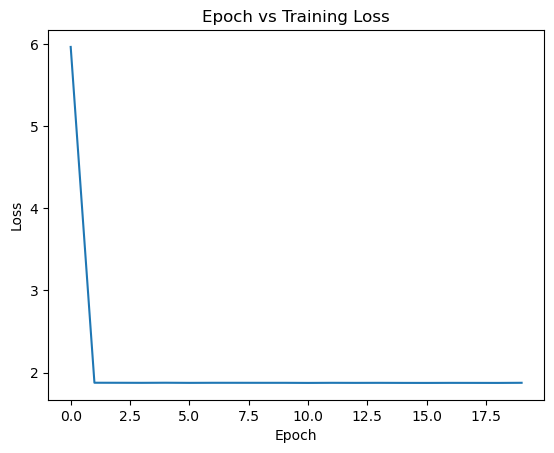

In [18]:

plt.plot(range(20),losses)
plt.title('Epoch vs Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
from torch.utils.data import DataLoader


test_set = PatchDataset(r'/kaggle/input/nectestdata/NecTestData.csv',
                        r'/kaggle/input/test-patches/Test_Patches')
test_loader = DataLoader(test_set,batch_size,shuffle=True,drop_last=True)
print("Total test patches", len(test_set))
print(test_set[2][1:])

Total test patches 2540
(8, 'C3L-04083-24')


In [18]:
# If loading model from saved weights
net = ConvNet()
net.load_state_dict(torch.load('/kaggle/input/20-epoch-weights/weights e-4 20'))
net.cuda()

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [19]:
err = 0
tot = 0

whole_slide = {}

loader = test_loader
output_all = []
labels_all = []

with torch.no_grad():
    for data in loader:
        
        # where X is the image and y is the label (see custom dataset above)
        X = data[0].to(device)
        y = data[1].to(device)
        slide_ID = data[2]

        # raw output of network for X
        output = net(X)
        # softmax on output layer in training did not work
        output = F.softmax(output,dim=1)
        
        # maximum index is predicted class
        _, yh = torch.max(output,1)
        
        for patch in output :
            output_all += [patch.detach().to('cpu').numpy()]
        for patch in y :
            labels_all += [patch.detach().to('cpu').numpy()]
        
        # group patch predictions by slide
        for i in range(len(output)) :
            # for label in range(len(output[0])) :
                # yh[i] += label * output[i][label]
            if slide_ID[i] not in whole_slide :
                whole_slide[slide_ID[i]] = [yh[i].item()]
            else :
                whole_slide[slide_ID[i]].append(yh[i].item())
                
            
       

        tot += y.size(0)

        
        err += torch.count_nonzero(y-yh)
        
            
print('Accuracy of prediction on test digits: %5.2f%%' % (100-100 * err / tot))
print('Total inputs (patches): ', tot)

Accuracy of prediction on test digits: 31.88%
Total inputs (patches):  2528


In [49]:
#print(whole_slide.keys())
labels_all[0].item()

6

# Metrics by patch
Evaluating the model performance on patches, rather than whole slide

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1802: UndefinedMetricWarning: 'k' (10) greater than or equal to 'n_classes' (10) will result in a perfect score and is therefore meaningless.
  warnings.warn(


AUC score one-vs-rest 0.6777690113913781
AUC score one-vs-one 0.6777690113913781
F1 score 0.15611750201336203
Balanced accuracy 15.48%


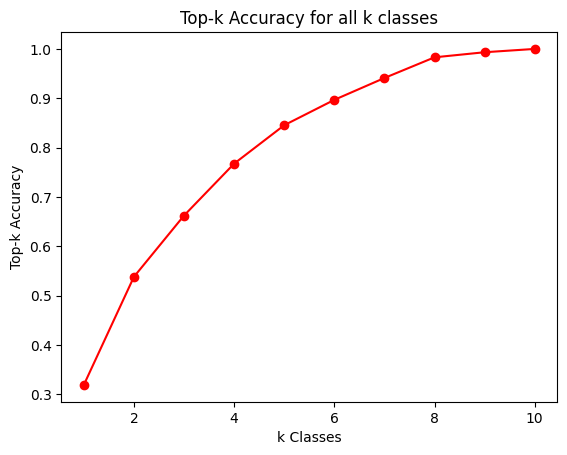

[0.3188291139240506,
 0.5379746835443038,
 0.6621835443037974,
 0.7674050632911392,
 0.8453322784810127,
 0.896756329113924,
 0.9410601265822784,
 0.9829905063291139,
 0.9932753164556962,
 1.0]

In [22]:
from sklearn import metrics
# need arrays of shape n_samples, n_classes for metrics
# convert true labels to one-hot vector
# output_all softmax outputs of shape [num_patches, 10]
# labels_all correct labels (0-9) of shape [num_patches,]
# predictions predicted labels (0-9) of shape [num_patches,]
# one_hot_* correct/predicted labels as one-hot vectors with 1 at label index and 0s elsewhere

for i in range(len(labels_all)) :
    labels_all[i] = labels_all[i].item()

one_hot_labels = np.zeros([len(labels_all),10])
for i, label in enumerate(labels_all) :
    one_hot_labels[i][label] = 1

predictions = np.argmax(output_all, axis=1)

one_hot_pred = np.zeros([len(labels_all),10])
for i, label in enumerate(predictions) :
    one_hot_pred[i][label] = 1



score_ovr = metrics.roc_auc_score(one_hot_labels, output_all, average='macro',multi_class='ovr')
score_ovo = metrics.roc_auc_score(one_hot_labels, output_all, average='macro',multi_class='ovo')
f1 = metrics.f1_score(one_hot_labels, one_hot_pred, average='macro')
acc = metrics.balanced_accuracy_score(labels_all, predictions)

topk = []
for k in range(1,11) :
    topk += [metrics.top_k_accuracy_score(labels_all, output_all,k=k)]


print("AUC score one-vs-rest", score_ovr)
print("AUC score one-vs-one", score_ovo)
print('F1 score', f1)
print('Balanced accuracy %5.2f%%' % (acc*100))
plt.plot(range(1,11), topk, 'o-r')
plt.title('Top-k Accuracy for all k classes')
plt.xlabel('k Classes')
plt.ylabel('Top-k Accuracy')
plt.show()
topk

ROC AUC score: 0.5335232969887591


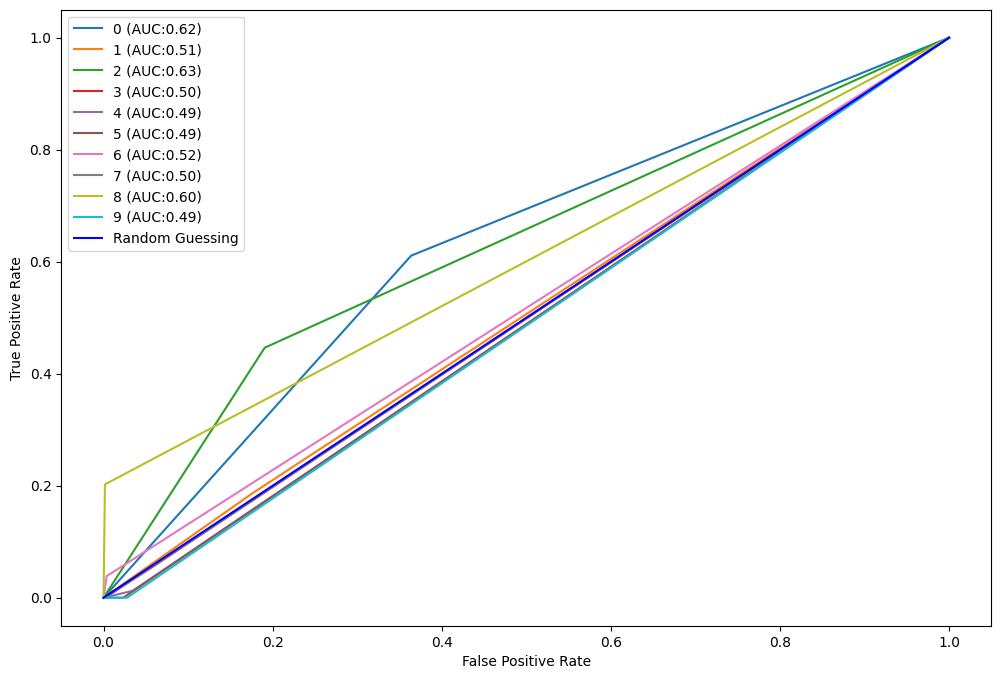

In [23]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= range(10)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels_all, predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# Metrics by slide
Evaluating model performance according to whole slide label and prediction

In [14]:
labels = []
predictions = []
for item in whole_slide :
    pred_label = np.mean(whole_slide[item])
    predictions.append(pred_label)
    true_label = test_set.slide_map[item]
    labels.append(true_label)


# predictions, labels
print(len(labels))
print(len(predictions))
predictions = np.ceil(predictions).astype(int)

46
46


In [16]:
from sklearn import metrics
# need arrays of shape n_samples, n_classes for metrics
# convert true labels to one-hot vector
# output_all softmax outputs of shape [num_patches, 10]
# labels_all correct labels (0-9) of shape [num_patches,]
# predictions predicted labels (0-9) of shape [num_patches]
# one_hot_* correct/predicted labels as one-hot vectors with 1 at label index and 0s elsewhere

one_hot_labels = np.zeros([len(labels),10])
for i, label in enumerate(labels) :
    one_hot_labels[i][label] = 1


one_hot_pred = np.zeros([len(labels),10])
for i, label in enumerate(predictions) :
    one_hot_pred[i][label] = 1



score_ovr = metrics.roc_auc_score(one_hot_labels, one_hot_pred, average='macro',multi_class='ovr')
score_ovo = metrics.roc_auc_score(one_hot_labels, one_hot_pred, average='macro',multi_class='ovo')
f1 = metrics.f1_score(one_hot_labels, one_hot_pred, average='macro')
balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
acc = metrics.accuracy_score(labels, predictions)


print("AUC score one-vs-rest", score_ovr)
print("AUC score one-vs-one", score_ovo)
print('F1 score', f1)
print('Balanced accuracy %5.2f%%' % (balanced_acc*100))
print('Accuracy %5.2f%%' % (acc*100))


AUC score one-vs-rest 0.5139044356195519
AUC score one-vs-one 0.5139044356195519
F1 score 0.09238095238095238
Balanced accuracy 12.02%
Accuracy 23.91%
